In [2]:
#Execute celula por celula até a resolução do problema
#instala a versão mais recente com suporte a GPU diretamente
!pip install -q "tensorflow[and-cuda]"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires nvidia-cublas-cu12==12.6.4.1; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.8.0+cu126 requires nvidia-cuda-cupti-cu12==12.6.80; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.8.0+cu126 requires nvidia-cuda-nvrtc-cu12==12.6.77; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.8.0+cu126 requires nvidia-cuda-runtime-cu12==12.6.77; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompatible.
torch 2.8.0+cu126 requires nvidia-cudnn-cu12==9.10.2.21; platform_system ==

In [3]:
import tensorflow as tf #rodar modelos que aproveitam aceleração por GPU
print("Versão do TensorFlow:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

Versão do TensorFlow: 2.19.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns

import pandas as pd

In [5]:
tf.__version__

'2.19.0'

In [6]:
%load_ext tensorboard

In [7]:
logdir='log'

In [8]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
            y=train_labels,
            epochs=5,
            validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8972 - loss: 0.3278 - val_accuracy: 0.9840 - val_loss: 0.0466
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9852 - loss: 0.0457 - val_accuracy: 0.9854 - val_loss: 0.0482
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9901 - loss: 0.0322 - val_accuracy: 0.9835 - val_loss: 0.0530
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.9893 - val_loss: 0.0318
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9939 - loss: 0.0182 - val_accuracy: 0.9913 - val_loss: 0.0272


In [12]:
y_true=test_labels
y_pred=np.argmax(model.predict(test_images), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [13]:
classes=[0,1,2,3,4,5,6,7,8,9]

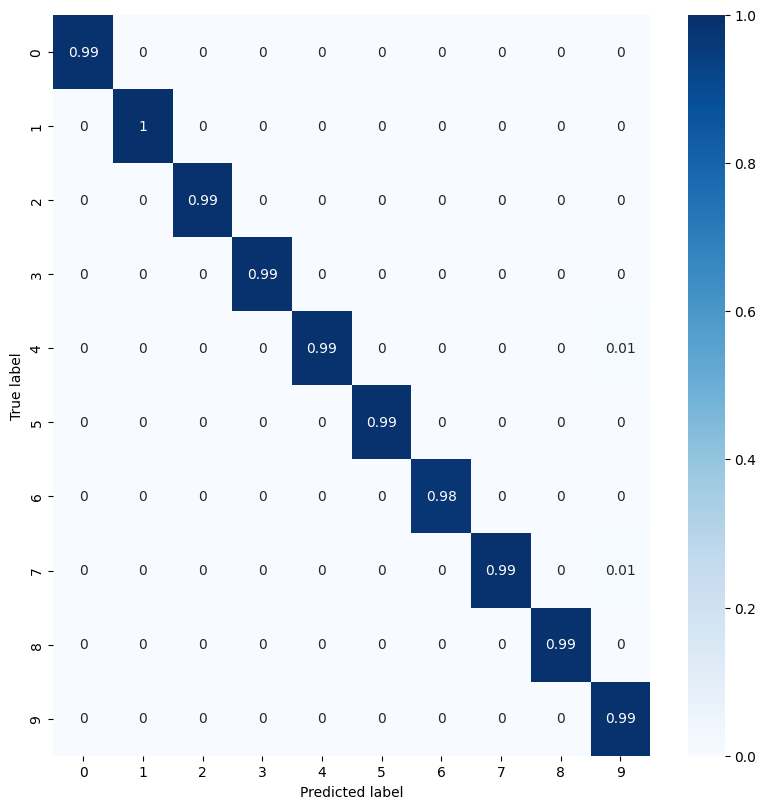

In [14]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
# Número de classes
num_classes = len(classes)

# Loop pelas classes para calcular métricas
for i in range(num_classes):
    # VP: valor na diagonal (acerto da classe i)
    VP = con_mat_norm[i, i]

    # FN: soma da linha da classe i, excluindo VP (erros da classe i)
    FN = np.sum(con_mat_norm[i, :]) - VP

    # FP: soma da coluna da classe i, excluindo VP (erros atribuídos à classe i)
    FP = np.sum(con_mat_norm[:, i]) - VP

    # VN: tudo que não está na linha nem na coluna da classe i
    VN = np.sum(con_mat_norm) - (VP + FP + FN)

    # Cálculo das métricas com proteção contra divisão por zero
    precisao = VP / (VP + FP) if (VP + FP) else 0
    recall = VP / (VP + FN) if (VP + FN) else 0
    especificidade = VN / (VN + FP) if (VN + FP) else 0
    f1 = 2 * precisao * recall / (precisao + recall) if (precisao + recall) else 0
    acuracia = (VP + VN) / np.sum(con_mat_norm)

    # Exibe os resultados
    print(f"Classe {i}: VP={VP:.2f}, FP={FP:.2f}, FN={FN:.2f}, VN={VN:.2f}")
    print(f"  Acurácia={acuracia:.2f}, Precisão={precisao:.2f}, Recall={recall:.2f}, Especificidade={especificidade:.2f}, F1-Score={f1:.2f}\n")

Classe 0: VP=0.99, FP=0.00, FN=0.00, VN=8.93
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 1: VP=1.00, FP=0.00, FN=0.00, VN=8.92
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 2: VP=0.99, FP=0.00, FN=0.00, VN=8.93
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 3: VP=0.99, FP=0.00, FN=0.00, VN=8.93
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 4: VP=0.99, FP=0.00, FN=0.01, VN=8.92
  Acurácia=1.00, Precisão=1.00, Recall=0.99, Especificidade=1.00, F1-Score=0.99

Classe 5: VP=0.99, FP=0.00, FN=0.00, VN=8.93
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 6: VP=0.98, FP=0.00, FN=0.00, VN=8.94
  Acurácia=1.00, Precisão=1.00, Recall=1.00, Especificidade=1.00, F1-Score=1.00

Classe 7: VP=0.99, FP=0.00, FN=0.01, VN=8.92
  Acurácia=1.00, Precisão=1.00, Recall=0.99, Especificidade=1.00, F1-Scor

In [16]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred = model1.predict_classes(test_images)

  con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=test_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)

  # Log the confusion matrix as an image summary.
  with file_writer.as_default():
    tf.summary.image("Confusion Matrix", image, step=epoch)


logdir='logs/images'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

NameError: name 'keras' is not defined

In [ ]:
model1.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)

In [ ]:
# Start TensorBoard.
%tensorboard --logdir logs/images